In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ["TENSORBOARD_BINARY"] = ".speech_recognition/bin/tensorboard"

from tensorflow.keras import backend as K
K.clear_session()

# tensorboard --logdir ./tensorboard --host "0.0.0.0" --port 8501

In [61]:
import h5py
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import LossScaleOptimizer
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import jiwer

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

pd.options.display.float_format = '{:.2f}'.format

os.makedirs("training_images", exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
log_dir = "tensorboard/"
os.makedirs(log_dir, exist_ok=True)

char_to_num = {char: idx + 1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
char_to_num['<PAD>'] = 0
num_to_char = {v: k for k, v in char_to_num.items()}
n_mfcc = 13

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [59]:
def check_dataset_size(dataset_filename: str):
    """Counts the number of samples in the HDF5 dataset"""
    with h5py.File(f"data/CommonVoice/{dataset_filename}", "r") as hf:
        mfcc_group = hf["mfcc"]
        labels_group = hf["labels"]
        i = 0
        for key in mfcc_group.keys():
            i += 1
    return i


def dataset_from_generator(h5_file_path):
    """Returns the generator for the dataset."""
    
    def generator():
        
        with h5py.File(h5_file_path, "r") as hf:
            mfcc_group = hf["mfcc"]
            labels_group = hf["labels"]
            
            for key in mfcc_group.keys():
                mfcc = mfcc_group[key][:]
                labels = labels_group[key][:]
                
                yield mfcc, labels
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 13), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        ))


def generate_padded_data(h5_file_path, batch_size=32):
    """Performs padding in batches."""
    dataset = dataset_from_generator(h5_file_path)
    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padded_shapes=(
            [None, 13],
            [None]
        ),
        padding_values=(
            0.0,
            char_to_num['<PAD>']
        ))
    
    # return dataset.repeat().prefetch(tf.data.AUTOTUNE)
    return dataset


def plot_loss_curves(history, model_name):
    """Return separate loss curves for training and validation results."""
    
    loss = history.history["val_loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(loss))

    plt.figure(figsize=(10, 5))

    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="val loss")
    plt.title(f"CTC loss for {model_name}")
    plt.xlabel("Epochs")
    plt.legend()
    plt.savefig(f"training_images/{model_name}.png")
    plt.show()


def build_model(model_name, layer_list, input_shape=(None, 13), vocab_size=len(char_to_num), learning_rate=1e-03, load_weights=""):
    """
    Creates a model from a list of layers using keras functional api; input and output is permanently defined.
    The returned model is compiled using CTC and Loss scale optimizer.
    """
        
    inputs = layers.Input(shape=input_shape, name="input_layer")

    x = inputs
    for layer in layer_list:
        x = layer(x)

    outputs = layers.Dense(units=vocab_size, name="output_layer")(x)

    model = Model(inputs, outputs, name=model_name)

    if len(load_weights) > 0:
         model.load_weights(f"checkpoints/{load_weights}.ckpt.weights.h5")

    model.compile(
        optimizer=LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=learning_rate)),
        loss=tf.keras.losses.CTC())
    
    return model


def train_model(model,
                train_data,
                val_data,
                train_data_size,
                val_data_size,
                batch_size=32,
                epochs=20,
                initial_epoch=0,
                callbacks=None):
    "Trains model, plots and returns history."
    
    history = model.fit(
                train_data,
                validation_data=val_data,
                epochs=epochs,
                steps_per_epoch=int(train_data_size/batch_size),
                validation_steps=int(val_data_size/batch_size),
                callbacks=callbacks,
                verbose=1,
                initial_epoch=initial_epoch
                )
    
    plot_loss_curves(history, model.name)

    return history


def decode(sequence, pred=True):
    """Decodes labels and predictions."""
    if pred:
        sequence = tf.argmax(sequence, axis=-1)
    sequence = tf.reshape(sequence, [-1])
    decoded = []
    for idx in sequence.numpy():
        char = num_to_char.get(idx, '')
        if char != '<PAD>':
            decoded.append(char)
    decoded = "".join(decoded)

    return " ".join(decoded.split())


def print_labels_and_predictions(test_dataset, model, num=10):
    labels = []
    predictions = []
    
    for data, label in test_dataset.rebatch(1).take(num):
        labels.append(label)
        pred = model.predict(data, verbose=False)
        predictions.append(pred)
    
    decoded_labels = []
    decoded_preds = []
    
    for l, p in zip(labels, predictions):
        decoded_labels.append(decode(l, pred=False))
        decoded_preds.append(decode(p, pred=True))
    
    for true_label, pred in zip(decoded_labels, decoded_preds):
        print(f"True: {true_label}")
        print(f"Pred: {pred}")
        print() 

    return decoded_labels, decoded_preds

# Loss Function

## CTC - Connectionist Temporal Classification
* Enables comparative analysis of sequences with different lengths, where there is no clear alignment between input and output, e.g., audio and transcription.
* Predictions are in the form of logits, blank index - 0; no additional function is used in the output layer.
* Loss value is normalized by default at the batch level - allows comparison of batches with samples of varying sizes.

# Types of Networks
* LSTM and GRU, unidirectional and bidirectional.
* 1D and 2D convolutional networks.

# Padding
Adding special values (usually zeros) to data sequences to align them to the same length, allowing the processing of data of varying sizes in models that require fixed-length input. The data is loaded from the shortest to the longest sequences to reduce padding, which occurs within batches. Afterward, the dataset is sorted at the batch level.

# Mixed Precision
* Using different precisions (e.g., 16-bit and 32-bit) to speed up computations and reduce memory usage.
* LossScaleOptimizer - a technique to scale the loss to prevent precision loss when calculating gradients in mixed precision. It involves multiplying the loss value by a constant (called the scale factor) and then, after computing the gradients, dividing them by the same factor. This helps avoid the issue of very small gradients, which can lead to instability during training.

# Loading dataset from generator

In [14]:
train_data_size = check_dataset_size("train.h5")
train_dataset = generate_padded_data("data/CommonVoice/train.h5").shuffle(buffer_size=train_data_size, seed=42).take(int(train_data_size/2)).repeat().prefetch(tf.data.AUTOTUNE)

test_dataset = generate_padded_data("data/CommonVoice/test.h5").repeat().prefetch(tf.data.AUTOTUNE)
test_data_size = check_dataset_size("test.h5")

val_data_size = check_dataset_size("val.h5")
val_dataset = generate_padded_data("data/CommonVoice/val.h5").shuffle(buffer_size=val_data_size, seed=42).take(int(val_data_size/2)).repeat().prefetch(tf.data.AUTOTUNE)

print(f"Train: {int(train_data_size/2)}, Val: {int(val_data_size/2)}, Test: {test_data_size}")

Train: 45161, Val: 5018, Test: 25090


In [9]:
for d, l in train_dataset.take(5):
    print(d.shape, l.shape)

(32, 288, 13) (32, 101)
(32, 313, 13) (32, 87)
(32, 331, 13) (32, 89)
(32, 275, 13) (32, 92)
(32, 294, 13) (32, 98)


In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
lstm_layer = tf.keras.layers.LSTM (256, use_cudnn=True)
print(lstm_layer.cell)

<LSTMCell name=lstm_cell, built=False>


# 1/2 of data for faster prototyping model architecture

In [11]:
input_shape = (None, 13)
dropout = 0.2

models = {
    "BLSTM": [
        layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
    ],
    "BGRU": [
        layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=dropout)),
        layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=dropout)),
    ],
    "CNN1D_BGRU": [
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=dropout)),
        layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=dropout)),
    ],
    "CNN1D_BLSTM": [
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
    ],
    "CNN2D_BLSTM": [
        layers.Reshape((-1, input_shape[1], 1)),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.TimeDistributed(layers.Flatten()),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
    ],
    "CNN2D_BGRU": [
        layers.Reshape((-1, input_shape[1], 1)),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.TimeDistributed(layers.Flatten()),
        layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=dropout)),
        layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=dropout)),
    ]
}


all_results = []
    
for name, layer_list in models.items():  
    model = build_model(name, layer_list)
    print(f"Training model {name}....")
    # print(model.summary())

    experiment_dir = f"{log_dir}50%/{name}"

    callbacks = [
    ModelCheckpoint(f"checkpoints/{name}.ckpt.weights.h5",
                   # save_best_only=True,
                   save_weights_only=True),
    EarlyStopping(patience=3,
                  restore_best_weights=True),
    TensorBoard(log_dir=experiment_dir,
                histogram_freq=1,
                write_steps_per_second=True)
    ]
    
    history = train_model(model, train_dataset, val_dataset,
                          callbacks=callbacks,
                          train_data_size=train_data_size/2,
                          val_data_size=val_data_size/2,
                          epochs=10)

    results = {
        "Model": name,
        "Params": model.count_params(),
        "Train loss": history.history["loss"][-1],
        "Val loss": history.history["val_loss"][-1],
        "Test loss": model.evaluate(test_dataset, verbose=0, steps=test_data_size//32)
    }
    all_results.append(results)

all_results = pd.DataFrame(all_results)
all_results.to_csv("50%_data_results.csv", index=False)

Primarily recurrent networks can be used to analyze MFCC data, but convolutional networks (both 1D and 2D) can also work well.

In this case, it seems that although convolutional networks greatly accelerated the training of the model, the information was reduced too much.

Moreover, the more complex LSTMs perform better than their simplified version, GRU, so LSTMs will be used in further tests.

![image.png](images/tensorboard_initial.png)

In [13]:
df = pd.read_csv("50%_data_results.csv")
results.style.background_gradient(subset=df.columns[1:]).format(subset=df.columns[2:], formatter="{:.2f}")

,Model,Params,Train loss,Val loss,Test loss
0,BLSTM,2142236,72.45,70.84,70.90
1,BGRU,1613340,78.25,76.93,77.01
2,CNN1D_BGRU,1694236,141.15,138.84,139.82
3,CNN1D_BLSTM,2249244,132.98,134.68,128.43
4,CNN2D_BLSTM,2902684,133.50,132.02,131.59
5,CNN2D_BGRU,2183836,139.89,140.15,139.49


## Predictions 

### In the form of RaggedTensor
* Allows storing data of varying sizes.
* Probabilities of each character at every time step are represented as logits.

![image.png](images/rag_tens.png)

### Checking decoded predictions
Of course, at this stage they are far from good, but nevertheless phonetically it is not so far.

In [16]:
name = "BLSTM"
layers_list =  models[name]
model = build_model(name, layer_list=layers_list, learning_rate=1e-03)
model.load_weights(f"checkpoints/{name}.ckpt.weights.h5")

In [22]:
decoded_labels, decoded_preds = print_labels_and_predictions(test_dataset, model)

True: pachman went on to become one of the worlds leading players
Pred: tastbenn onnhn the becoomm int a orrll llaavein playyerrss

True: he emigrated from england to pennsylvania where he married elizabeth welding
Pred: hhhe inrraated from gulinse to esomaa weere e arrry eliss bitth wwellli

True: other record companies rejected them seeing a potential only in rosendahl
Pred: otther rrecorrdd companneess rrrejecctted toum senng of heeteenntiiall unly an rrossann all

True: any party faction or politician may be labeled green if it emphasizes environmental causes
Pred: aporrrry raon worrrk ollobsittioonn anella pogrrren ia omm pesisess nn vorrmerntto n consess

True: he joined brown university as a coach
Pred: he joinn drronn inn vessity aass a cootn

True: sherriff also wrote prose
Pred: sshervff allssso ro prrillss

True: medieval moscow grew from its kremlin primarily in a northeasterly direction towards the yauza
Pred: the dival lossko grrffermencs cillln prevarrrilly ann a orttees

# Metrics
For the record – they will be terrible for now.

## CER - Character Error Rate
The ratio of incorrect characters in the predicted transcription to the total number of characters in the true transcription.

## WER - Word Error Rate
The ratio of incorrect words in the predicted transcription to the total number of words in the true transcription.

In [11]:
cer_values = [jiwer.cer(label, pred) for label, pred in zip(decoded_labels, decoded_preds)]
wer_values = [jiwer.wer(label, pred) for label, pred in zip(decoded_labels, decoded_preds)]
average_cer = sum(cer_values) / len(cer_values)
average_wer = sum(wer_values) / len(wer_values)

print(f"Average CER: {round(average_cer, 2)}")
print(f"Average WER: {round(average_wer, 2)}")

Average CER: 0.51
Average WER: 0.98


# Focus on LSTM

In [9]:
input_shape = (None, 13)
dropout = 0.2

models = {
    "BLSTM256x2_noD": [
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True))
    ],
    "BLSTM256x3_noD": [
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True))
    ],
    "BLSTM128x3_noD": [
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True))
    ],
    # "BLSTM256x3_2LN": [
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
    #     layers.LayerNormalization(),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
    #     layers.LayerNormalization(),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=dropout)),
    # ],
    # "BLSTM256x4_DLx4": [
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(0.1),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(0.1),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(0.1),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(0.1)
    #                          ],
    # "BLSTM256x6_DLx6": [
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(dropout),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(dropout),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(dropout),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(dropout),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(dropout),
    #     layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    #     layers.Dropout(dropout)
    # ]
}


all_results = []
all_results = [val for val in all_results.T.to_dict().values()]
    
for name, layer_list in models.items():  
    model = build_model(name, layer_list)
    print(f"Training model {name}....")
    # print(model.summary())

    experiment_dir = f"{log_dir}50%/{name}"

    callbacks = [
    ModelCheckpoint(f"checkpoints/{name}.ckpt.weights.h5", save_weights_only=True),
    EarlyStopping(patience=3,
                  restore_best_weights=True),
    TensorBoard(log_dir=experiment_dir,
                histogram_freq=1,
                write_steps_per_second=True)
    ]
    
    history = train_model(model, train_dataset, val_dataset,
                          callbacks=callbacks,
                          train_data_size=train_data_size/2,
                          val_data_size=val_data_size/2,
                          epochs=10)

    results = {
        "Model": name,
        "Params": model.count_params(),
        "Train loss": history.history["loss"][-1],
        "Val loss": history.history["val_loss"][-1],
        "Test loss": model.evaluate(test_dataset, verbose=0, steps=test_data_size//32)
    }
    all_results.append(results)

all_results = pd.DataFrame(all_results)
all_results.to_csv("50%_data_results_DL.csv", index=False)
all_results

In [10]:
pd.read_csv("50%_data_results_DL.csv")

,Model,Params,Train loss,Val loss,Test loss
0,BLSTM256x4_DLx4,5292060,44.95,38.35,38.03
1,BLSTM256x6_DLx6,8441884,167.11,165.18,164.19
2,BLSTM256x2_noD,2142236,56.34,52.63,52.66
3,BLSTM256x3_noD,3717148,41.55,37.48,37.25
4,BLSTM128x3_noD,941084,56.01,54.17,53.75


In [7]:
name = "BLSTM256x3_noD"
layers_list =  models[name]
model = build_model(name, layer_list=layers_list, learning_rate=1e-03, load_weights=name)

experiment_dir = f"{log_dir}50%/{name}"

callbacks = [
ModelCheckpoint(f"checkpoints/{name}.ckpt.weights.h5",
               save_weights_only=True),
EarlyStopping(patience=3,
              restore_best_weights=True),
TensorBoard(log_dir=experiment_dir,
            histogram_freq=1,
            write_steps_per_second=True),
ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-07)
]

history = train_model(model, train_dataset, val_dataset,
                          callbacks=callbacks,
                          train_data_size=train_data_size/2,
                          val_data_size=val_data_size/2,
                          initial_epoch=10,
                          batch_size=64,
                          epochs=65)

![image.png](images/blstm256x3.png)

In [18]:
model.evaluate(test_dataset, verbose=0, steps=test_data_size//128)

8.835699081420898

In [20]:
decoded_labels, decoded_preds = print_labels_and_predictions(test_dataset, model)

True: pachman went on to become one of the worlds leading players
Pred: pacchman whent on do beecome one of the worrllds lleading pllayyeerrss

True: he emigrated from england to pennsylvania where he married elizabeth welding
Pred: hhee emmiggraatted ffrom enngllanddd to ppennsylvvanniaa where he marriied ellizaabethh wwellldinngg

True: other record companies rejected them seeing a potential only in rosendahl
Pred: oottherr rreccorrd coommpanniiess rrrejectttedd tthemm sseingg a poottenntiiall onllyy in rrosenndallll

True: any party faction or politician may be labeled green if it emphasizes environmental causes
Pred: annyy porrtyy raaccttioonn orrrpolllitiiciiaann may bbe laabbbled ggrrreeeennn ifff itt deempheasizzeess envirrronmennttalll ccaauusesss

True: he joined brown university as a coach
Pred: hhhhe jooinned brrom unnnveerrssityy aass aa cooucch

True: sherriff also wrote prose
Pred: sherifff allssoo wrotee prroosee

True: medieval moscow grew from its kremlin primarily in 

# Speed up - 100% data, batch size 128

In [13]:
train_data_size = check_dataset_size("train.h5")
train_dataset = generate_padded_data("data/CommonVoice/train.h5", batch_size=128).shuffle(buffer_size=train_data_size, seed=42).repeat().prefetch(tf.data.AUTOTUNE)

test_dataset = generate_padded_data("data/CommonVoice/test.h5", batch_size=128).repeat().prefetch(tf.data.AUTOTUNE)
test_data_size = check_dataset_size("test.h5")

val_data_size = check_dataset_size("val.h5")
val_dataset = generate_padded_data("data/CommonVoice/val.h5", batch_size=128).repeat().prefetch(tf.data.AUTOTUNE)

print(f"Train: {int(train_data_size)}, Val: {int(val_data_size)}, Test: {test_data_size}")

Train: 90322, Val: 10036, Test: 25090


In [58]:
name = "BLSTM256x3_noD_b128"
layers_list =  [layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
                layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
                layers.Bidirectional(layers.LSTM(256, return_sequences=True))]
model = build_model(name, layer_list=layers_list, learning_rate=1e-03)

experiment_dir = f"{log_dir}100%/{name}"

callbacks = [
ModelCheckpoint(f"checkpoints/{name}.ckpt.weights.h5",
               save_weights_only=True),
EarlyStopping(patience=3,
              restore_best_weights=True),
TensorBoard(log_dir=experiment_dir,
            histogram_freq=1,
            write_steps_per_second=True),
ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-07)
]

history = train_model(model, train_dataset, val_dataset,
                          callbacks=callbacks,
                          train_data_size=train_data_size,
                          val_data_size=val_data_size,
                          initial_epoch=0,
                          batch_size=128,
                          epochs=150)

model = build_model(name, layer_list=layers_list, learning_rate=1e-03, load_weights=name)
print(f"Test loss: {model.evaluate(test_dataset, verbose=0, steps=test_data_size//128)}")

Test loss: 0.20007380843162537


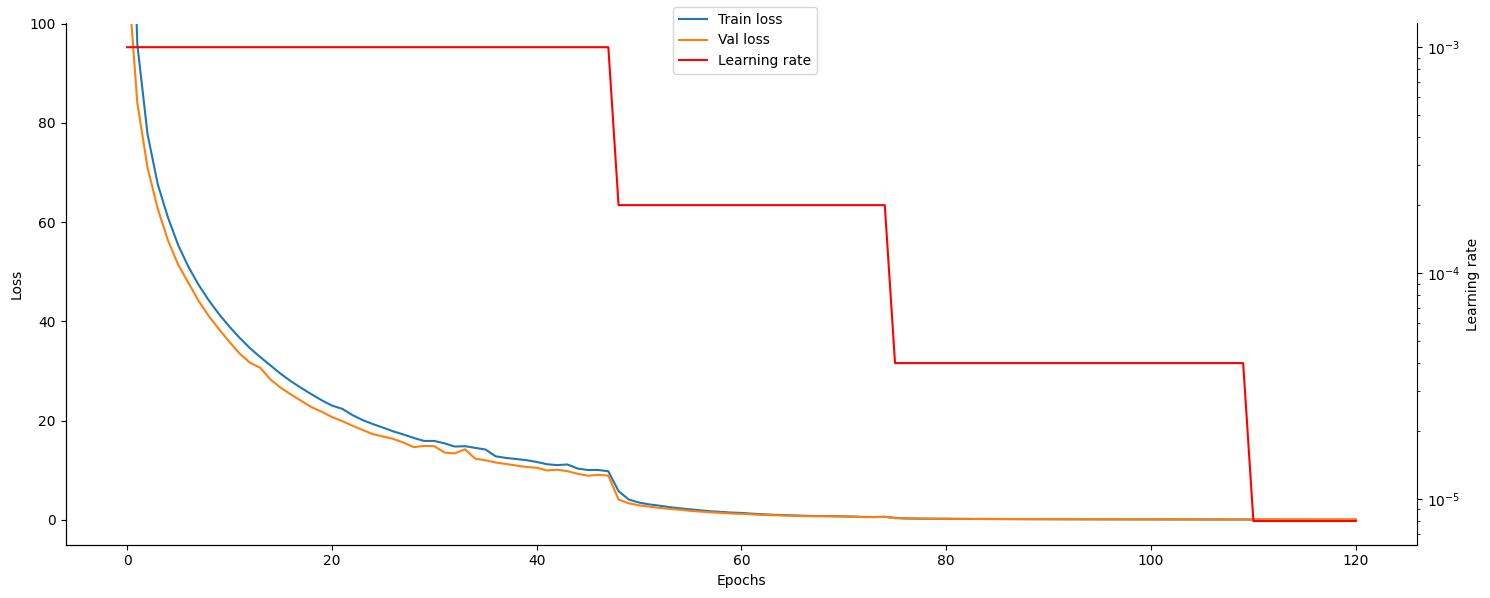

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(training.Step, training["Train loss"], label='Train loss')
ax.plot(training.Step, training["Val loss"], label='Val loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((-5, 100))
ax2 = ax.twinx()  
ax2.plot(training.Step, training.Lr.values, label='Learning rate', c="r")
ax2.set_ylabel('Learning rate')
ax2.spines['right'].set_visible(True)
fig.tight_layout()
ax2.set_yscale("log")
fig.legend(loc="upper center")
fig.tight_layout();

In [62]:
decoded_labels, decoded_preds = print_labels_and_predictions(test_dataset, model)
print()

cer_values = [jiwer.cer(label, pred) for label, pred in zip(decoded_labels, decoded_preds)]
wer_values = [jiwer.wer(label, pred) for label, pred in zip(decoded_labels, decoded_preds)]
average_cer = sum(cer_values) / len(cer_values)
average_wer = sum(wer_values) / len(wer_values)

print(f"Average CER: {round(average_cer, 2)}")
print(f"Average WER: {round(average_wer, 2)}")

True: pachman went on to become one of the worlds leading players
Pred: pachmann weent on to beecoome one of the worrlds leaadingg plaayyerrsss

True: he emigrated from england to pennsylvania where he married elizabeth welding
Pred: hheee emmiggraattedd from enngllanndd tto pennsyllvaanniiaa wherre he marrrieed elizaabetth welldiingg

True: other record companies rejected them seeing a potential only in rosendahl
Pred: ottherr rreecoord ccompaanniess rrejecctted themm ssseeeing aa ppootentiiaal onnllyy inn rrosseennddahll

True: any party faction or politician may be labeled green if it emphasizes environmental causes
Pred: any parrrrtyy facctiion orr pollliticiiaann mmayy bbe llabelled ggrreeeenn ifff itt emmmpphasizzzeess envirronmeenntaalll caausess

True: he joined brown university as a coach
Pred: hhhe jjoooiiinned brrrowwnn unnivverrrsityy aass aa cooaaachh

True: sherriff also wrote prose
Pred: ssherrriff allsso wrote prroossee

True: medieval moscow grew from its kremlin prima